In [ ]:
pip install ipdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.4 MB/s eta 0:00:00


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Particle competition for complex network community detection
### Summary of the Process  
1. Initialization: Start with several particles placed randomly in the network, each with low potential.  
2. Iteration: In each step, particles choose a neighboring node to visit based in a mix of random and deterministic rules.  
3. Update Ownership: Depending on the visit outcome, update the ownership and potential of both the particle and the node.  
4. Convergence: Repeat the process until each community is owned by a single particle, indicating successful community detection.  


# Inicialização
1. Criação de um network simples

In [ ]:
nxG = nx.Graph()

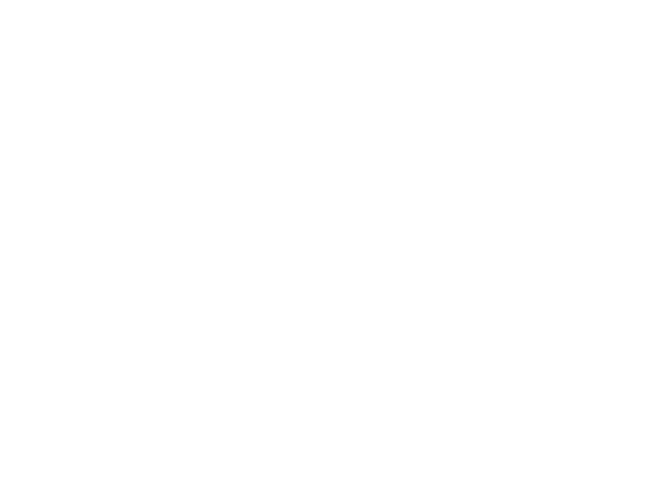

In [ ]:
nx.draw(nxG)

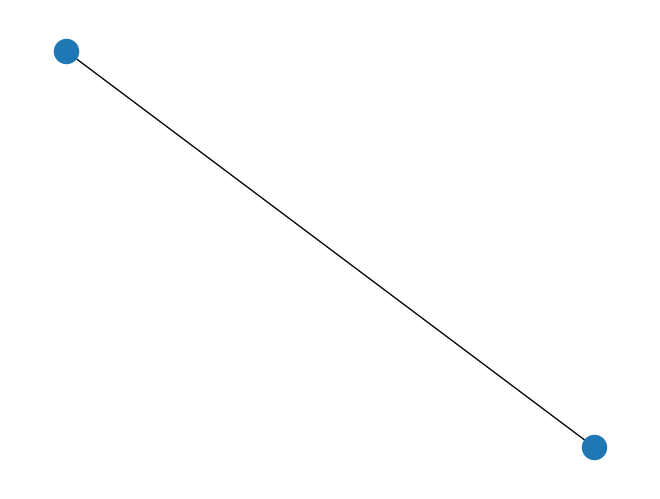

In [ ]:
nxG.add_node(1)
nxG.add_edge(1,2)
nx.draw(nxG)

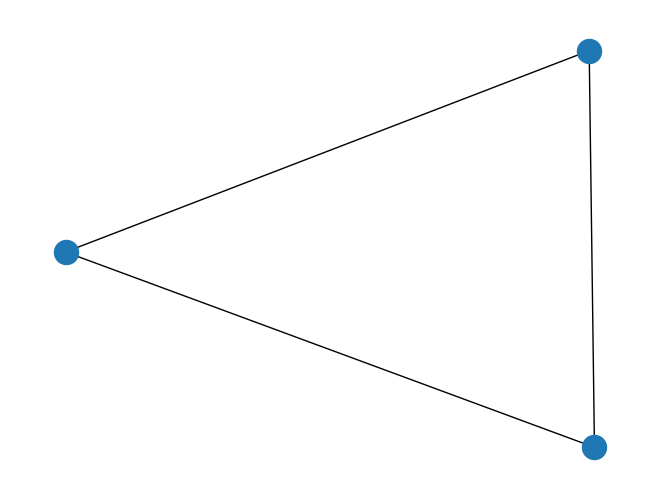

In [ ]:
# triangle
nxG.add_edge(1,2)
nxG.add_edge(1,3)
nxG.add_edge(2,3)
nx.draw(nxG)

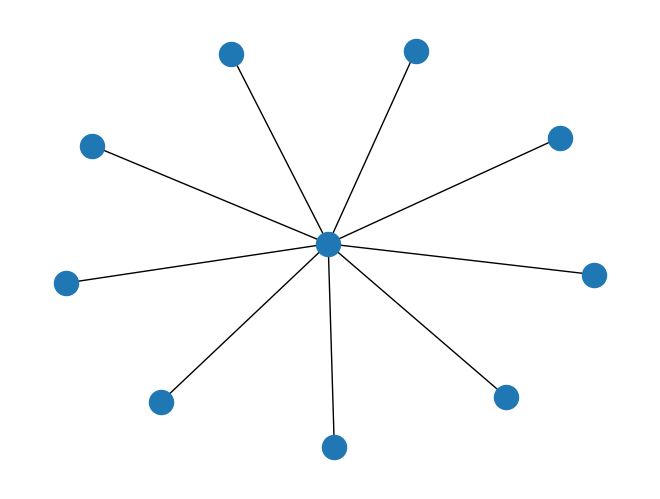

In [ ]:
nxG.clear()
nxnodelist = list(range(1,11))
nxG.add_nodes_from(nxnodelist)
nxedgelist = [(1,2),(1,3),(1,4),(1,5),(1,6),(1,7),(1,8),(1,9),(1,10)]
nxG.add_edges_from(nxedgelist)
nx.draw(nxG)

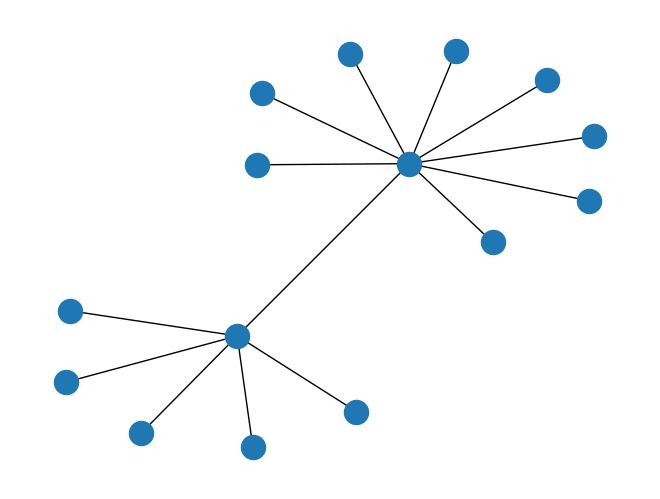

In [ ]:
nxnodelist2 = [11,12,13,14,15]
nxG.add_nodes_from(nxnodelist2)
nxedgelist2 = [(4,11),(4,12),(4,13),(4,14),(4,15)]
nxG.add_edges_from(nxedgelist2)
nx.draw(nxG)

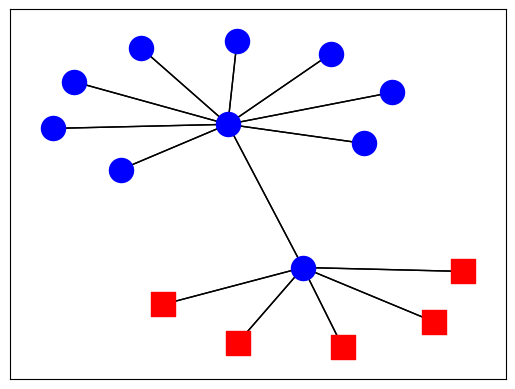

In [ ]:
pos = nx.spring_layout(nxG)
nx.draw_networkx_nodes(nxG, pos, nodelist = nxnodelist, node_color = 'b', node_shape = 'o')
nx.draw_networkx_edges(nxG, pos, nodelist=nxedgelist)
nx.draw_networkx_nodes(nxG, pos, nodelist = nxnodelist2, node_color = 'r', node_shape = 's')
nx.draw_networkx_edges(nxG, pos, nodelist=nxedgelist2)


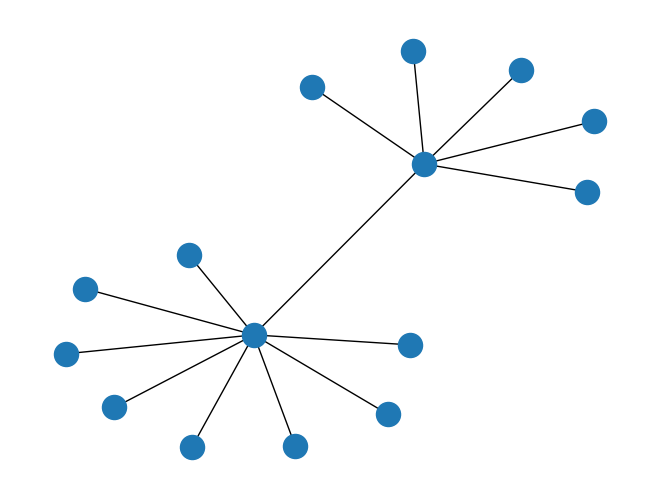

In [ ]:
nx.draw(nxG)

2. Criação de uma rede aleatória clusterizada

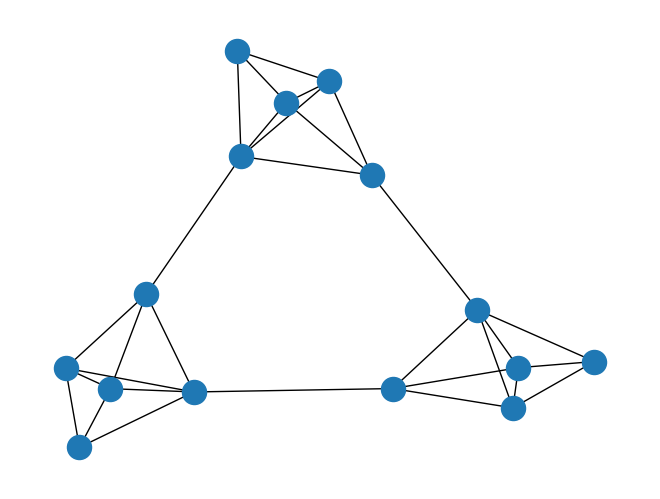

In [ ]:
G = nx.connected_caveman_graph(3, 5)
nx.draw(G)

# FINAL

In [ ]:
class OrderedSet:
    def __init__(self):
        self.items = []
        self.set = set()  # Tracks uniqueness

    def add(self, value):
        """Adds a unique value while maintaining order."""
        if value not in self.set:
            self.items.append(value)
            self.set.add(value)

    def remove_last(self):
        """Removes and returns the last item."""
        if self.items:
            value = self.items.pop()  # Remove from the list
            self.set.remove(value)  # Remove from the set
            return value
        raise IndexError("remove_last() called on empty OrderedSet")

    def get_last(self):
        """Returns the last item without removing it."""
        if self.items:
            return self.items[-1]
        raise IndexError("get_last() called on empty OrderedSet")

    def __contains__(self, value):
        """Check if the value exists in the set."""
        return value in self.set

    def __iter__(self):
        """Allows iteration over the items."""
        return iter(self.items)

    def __len__(self):
        """Returns the number of items."""
        return len(self.items)

    def __repr__(self):
        """String representation of the OrderedSet."""
        return f"OrderedSet({self.items})"


In [ ]:
class Particle:
    def __init__(self, id):
        self.id = id
        self.potential = 0.05  # min potential
        self.visited_nodes = OrderedSet() # owned nodes

class Node:
    def __init__(self):
        #self.id = id
        self.owner = None  # Owner particle (0 if free)
        self.potential = 0.05  # Initial potential (min)
 #       self.visited = 0  # Is the node being visited?

def move_particle(particle, graph):
      '''
      The particle can visit a node it already visited or a random
      neighbor(position is from last visited from the last iteration)

      Args:
        particle (Particle): particle
        graph (Graph): graph
      '''

      if len(particle.visited_nodes) == 0: # Checks if it's the first iteration of the particle
        return random.choice(list(graph.nodes))
      if random.random() < p_det:  # Deterministic movement
        # Prefer to visit owned nodes
        owned_nodes = [n for n in particle.visited_nodes if graph.has_node(n)]
        if owned_nodes:
          return random.choice(owned_nodes)
      else:
        # Random movement - select from current neighbors
        #import ipdb; ipdb.set_trace()
        current_node = particle.visited_nodes.get_last()
        neighbors = list(graph.neighbors(current_node))
        return random.choice(neighbors)

def update_particle(G, particle, node, delta_v = 0.3, delta_p = 0.4):
  '''
  Dynamics of particles and dynamics of nodes

  Args:
    G (Graph): graph
    particle (Particle): particle
    node(Node): node the particle selected
    delta_v (float): potential changing rate of the node
    delta_p (float): potential changing rate of the particle
  '''
  if G.nodes[node]['data'].owner == None:
    # Case 1: node is free
    particle.visited_nodes.add(node) # add to particle's owned nodes
    G.nodes[node]['data'].owner = particle.id # add particle to the node's current owner
    G.nodes[node]['data'].potential = particle.potential # unowned node receives the new owner potential
  elif G.nodes[node]['data'].owner == particle.id:
    # Case 2: node it's owned by the current particle
    particle.potential = particle.potential + ((1 - particle.potential) * delta_p)  # increase potential
    particle.potential = min(1, particle.potential)
    G.nodes[node]['data'].potential = particle.potential # node receives the node's potential

  else:
    # Case 3: node it's owned by another particle
    particle.potential = particle.potential - ((particle.potential - 0.05) * delta_p)  # decrease potential
    #G.nodes[node]['data'].potential = max(0.05, G.nodes[node]['data'].potential - delta_v)  # decrease node potential
    G.nodes[node]['data'].potential = G.nodes[node]['data'].potential - delta_v  # decrease node potential
    if node in particle.visited_nodes:
      particle.visited_nodes.remove_last() # pops the particle from the node's visited nodes if the node got owned by another particle

    if particle.potential < 0.05:
      #If particle is reduced below min, it isreset to a randomly chosen node and its potential is setto the minimum level, min.
      particle.potential = 0.05
      free_node = get_free_node(G)
      particle.visited_nodes = [free_node]
      G.nodes[free_node]['data'].owner = particle.id

    if G.nodes[node]['data'].potential < 0.05:
      G.nodes[node]['data'].owner = None  # node becomes unowned

def get_free_node(G):
  '''
  Get a node that is free for a reseted particle
  '''
  for n in G.nodes():
    if G_sim.nodes[n]['data'].owner == None:
      return n

def run_simulation(G, num_particles, iterations):
    particles = [Particle(i) for i in range(num_particles)]
    #nodes = {n: Node() for n in G.nodes}
    for node in G.nodes():
          G.nodes[node]['data'] = Node()  # add the custom Node object as a node attribute

    for _ in range(iterations):
        for particle in particles:
            node = move_particle(particle, G)
            update_particle(G, particle, node)

    return G, particles

def visualize_communities(G):
    color_map = []
    for node in G.nodes:
        color_map.append(G.nodes[node]['data'].owner)  # Color by owner
    nx.draw(G, node_color=color_map, with_labels=True)
    plt.show()


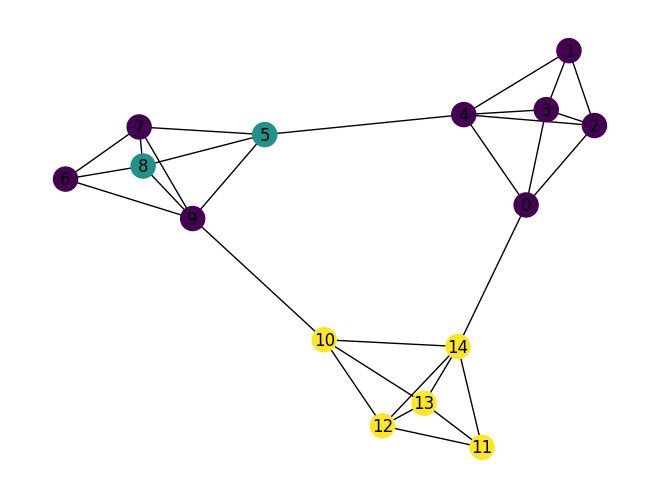

In [ ]:

p_det = 0.6  # Probability of deterministic movement
iterations = 9000 # Number of iterations
M = 3
G_sim, parts = run_simulation(G, M, iterations)
visualize_communities(G_sim)

In [ ]:
parts[2].visited_nodes

[1, 2, 3, 7, 7, 7, 7, 7, 7, 7, 7, 3, 4, 4, 2, 0]

In [ ]:
G_sim.nodes[7]['data'].potential

0.969624021167857

Visualização

Simulação